In [1]:
import os
import keras
import numpy as np
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications import EfficientNetB0
import pandas as pd
from sklearn.utils import class_weight

2025-04-29 13:31:50.422544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745933510.617518      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745933510.677925      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCH = 25
LEARNING_RATE = 3e-4
INPUT_SHAPE = (224, 224, 3)
NUM_CLASSES = 100

train_ds_path = "/kaggle/input/sports-classification/train"
val_ds_path = "/kaggle/input/sports-classification/valid"
test_ds_path = "/kaggle/input/sports-classification/test"

In [3]:
train_ds = keras.utils.image_dataset_from_directory(
    train_ds_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

val_ds = keras.utils.image_dataset_from_directory(
    val_ds_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

test_ds = keras.utils.image_dataset_from_directory(
    test_ds_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
)

Found 13492 files belonging to 100 classes.


I0000 00:00:1745933567.723132      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 500 files belonging to 100 classes.
Found 500 files belonging to 100 classes.


In [5]:
int2label = dict(enumerate(train_ds.class_names))

In [29]:
all_labels = []
for _, labels in train_ds.unbatch():
    class_index = np.argmax(labels.numpy())
    all_labels.append(class_index)
all_labels = np.array(all_labels)

# Get unique classes
classes = np.unique(all_labels)

# Compute class weights using sklearn's compute_class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=all_labels
)

# Map class indices to weights in a dictionary
class_weight_dict = dict(zip(classes, class_weights))

print("Class weights:", class_weight_dict)

Class weights: {0: 1.2046428571428571, 1: 1.2046428571428571, 2: 1.0221212121212122, 3: 1.3628282828282827, 4: 1.1939823008849557, 5: 0.9178231292517007, 6: 1.096910569105691, 7: 0.7754022988505748, 8: 0.7983431952662722, 9: 1.2492592592592593, 10: 1.2265454545454546, 11: 0.9304827586206896, 12: 0.9637142857142857, 13: 0.9776811594202899, 14: 1.1243333333333334, 15: 1.163103448275862, 16: 0.905503355704698, 17: 1.07936, 18: 0.8226829268292682, 19: 1.0299236641221374, 20: 1.1243333333333334, 21: 1.0458914728682172, 22: 1.006865671641791, 23: 0.9568794326241135, 24: 1.096910569105691, 25: 0.9994074074074074, 26: 0.8593630573248408, 27: 1.0540625, 28: 0.8935099337748345, 29: 0.8593630573248408, 30: 1.006865671641791, 31: 0.7063874345549738, 32: 0.7101052631578947, 33: 1.0299236641221374, 34: 1.1433898305084746, 35: 0.8994666666666666, 36: 0.8593630573248408, 37: 1.1059016393442622, 38: 1.1150413223140496, 39: 0.9178231292517007, 40: 0.8539240506329114, 41: 0.7844186046511628, 42: 1.006865

In [6]:
def build_model(num_classes):
    inputs = layers.Input(shape=INPUT_SHAPE)
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [7]:
model = build_model(num_classes=NUM_CLASSES)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [8]:
hist = model.fit(train_ds, epochs=EPOCH, validation_data=test_ds)

Epoch 1/25


I0000 00:00:1745933807.551669      97 service.cc:148] XLA service 0x7861140032c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745933807.552239      97 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745933809.323710      97 cuda_dnn.cc:529] Loaded cuDNN version 90300


  4/211 ━━━━━━━━━━━━━━━━━━━━ 9s 47ms/step - accuracy: 0.0915 - loss: 5.2575      

I0000 00:00:1745933818.878653      97 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


211/211 ━━━━━━━━━━━━━━━━━━━━ 73s 223ms/step - accuracy: 0.6665 - loss: 1.6776 - val_accuracy: 0.9200 - val_loss: 0.3339
Epoch 2/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9063 - loss: 0.3989 - val_accuracy: 0.9280 - val_loss: 0.2965
Epoch 3/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9269 - loss: 0.2906 - val_accuracy: 0.9380 - val_loss: 0.3442
Epoch 4/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9394 - loss: 0.2354 - val_accuracy: 0.9400 - val_loss: 0.2790
Epoch 5/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9485 - loss: 0.2063 - val_accuracy: 0.9380 - val_loss: 0.3077
Epoch 6/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9445 - loss: 0.2198 - val_accuracy: 0.9540 - val_loss: 0.3400
Epoch 7/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - accuracy: 0.9453 - loss: 0.2328 - val_accuracy: 0.9520 - val_loss: 0.3902
Epoch 8/25
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 45ms/step - accuracy: 0.9500 - loss: 0.2184 - val_accuracy:

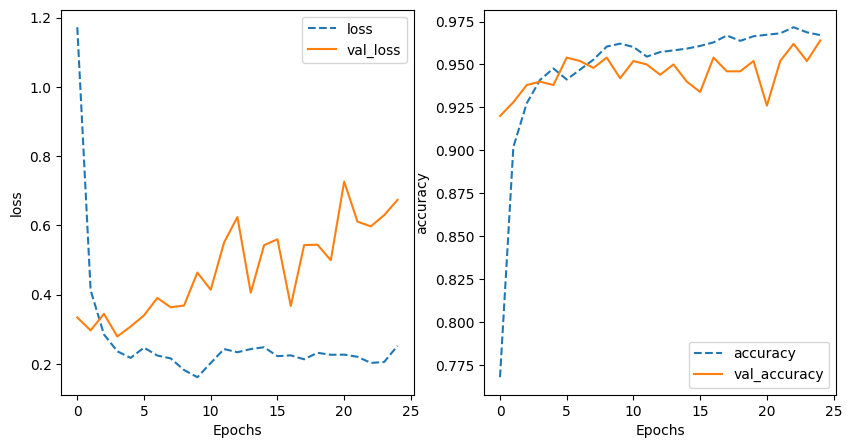

In [9]:
def training_plot(metrics, history):
    f, ax = plt.subplots(1, len(metrics), figsize=(5*len(metrics), 5))
    for idx, metric in enumerate(metrics):
        ax[idx].plot(history.history[metric], ls='dashed')
        ax[idx].set_xlabel("Epochs")
        ax[idx].set_ylabel(metric)
        ax[idx].plot(history.history['val_' + metric])
        ax[idx].legend([metric, 'val_' + metric])

training_plot(['loss', 'accuracy'], hist)

In [10]:
# Get class names from the test dataset
class_names = test_ds.class_names

# Create lists to store true labels and predictions
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    # Get predictions
    predictions = model.predict(images, verbose=0)
    
    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Extend the lists with batch data
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(predicted_classes)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

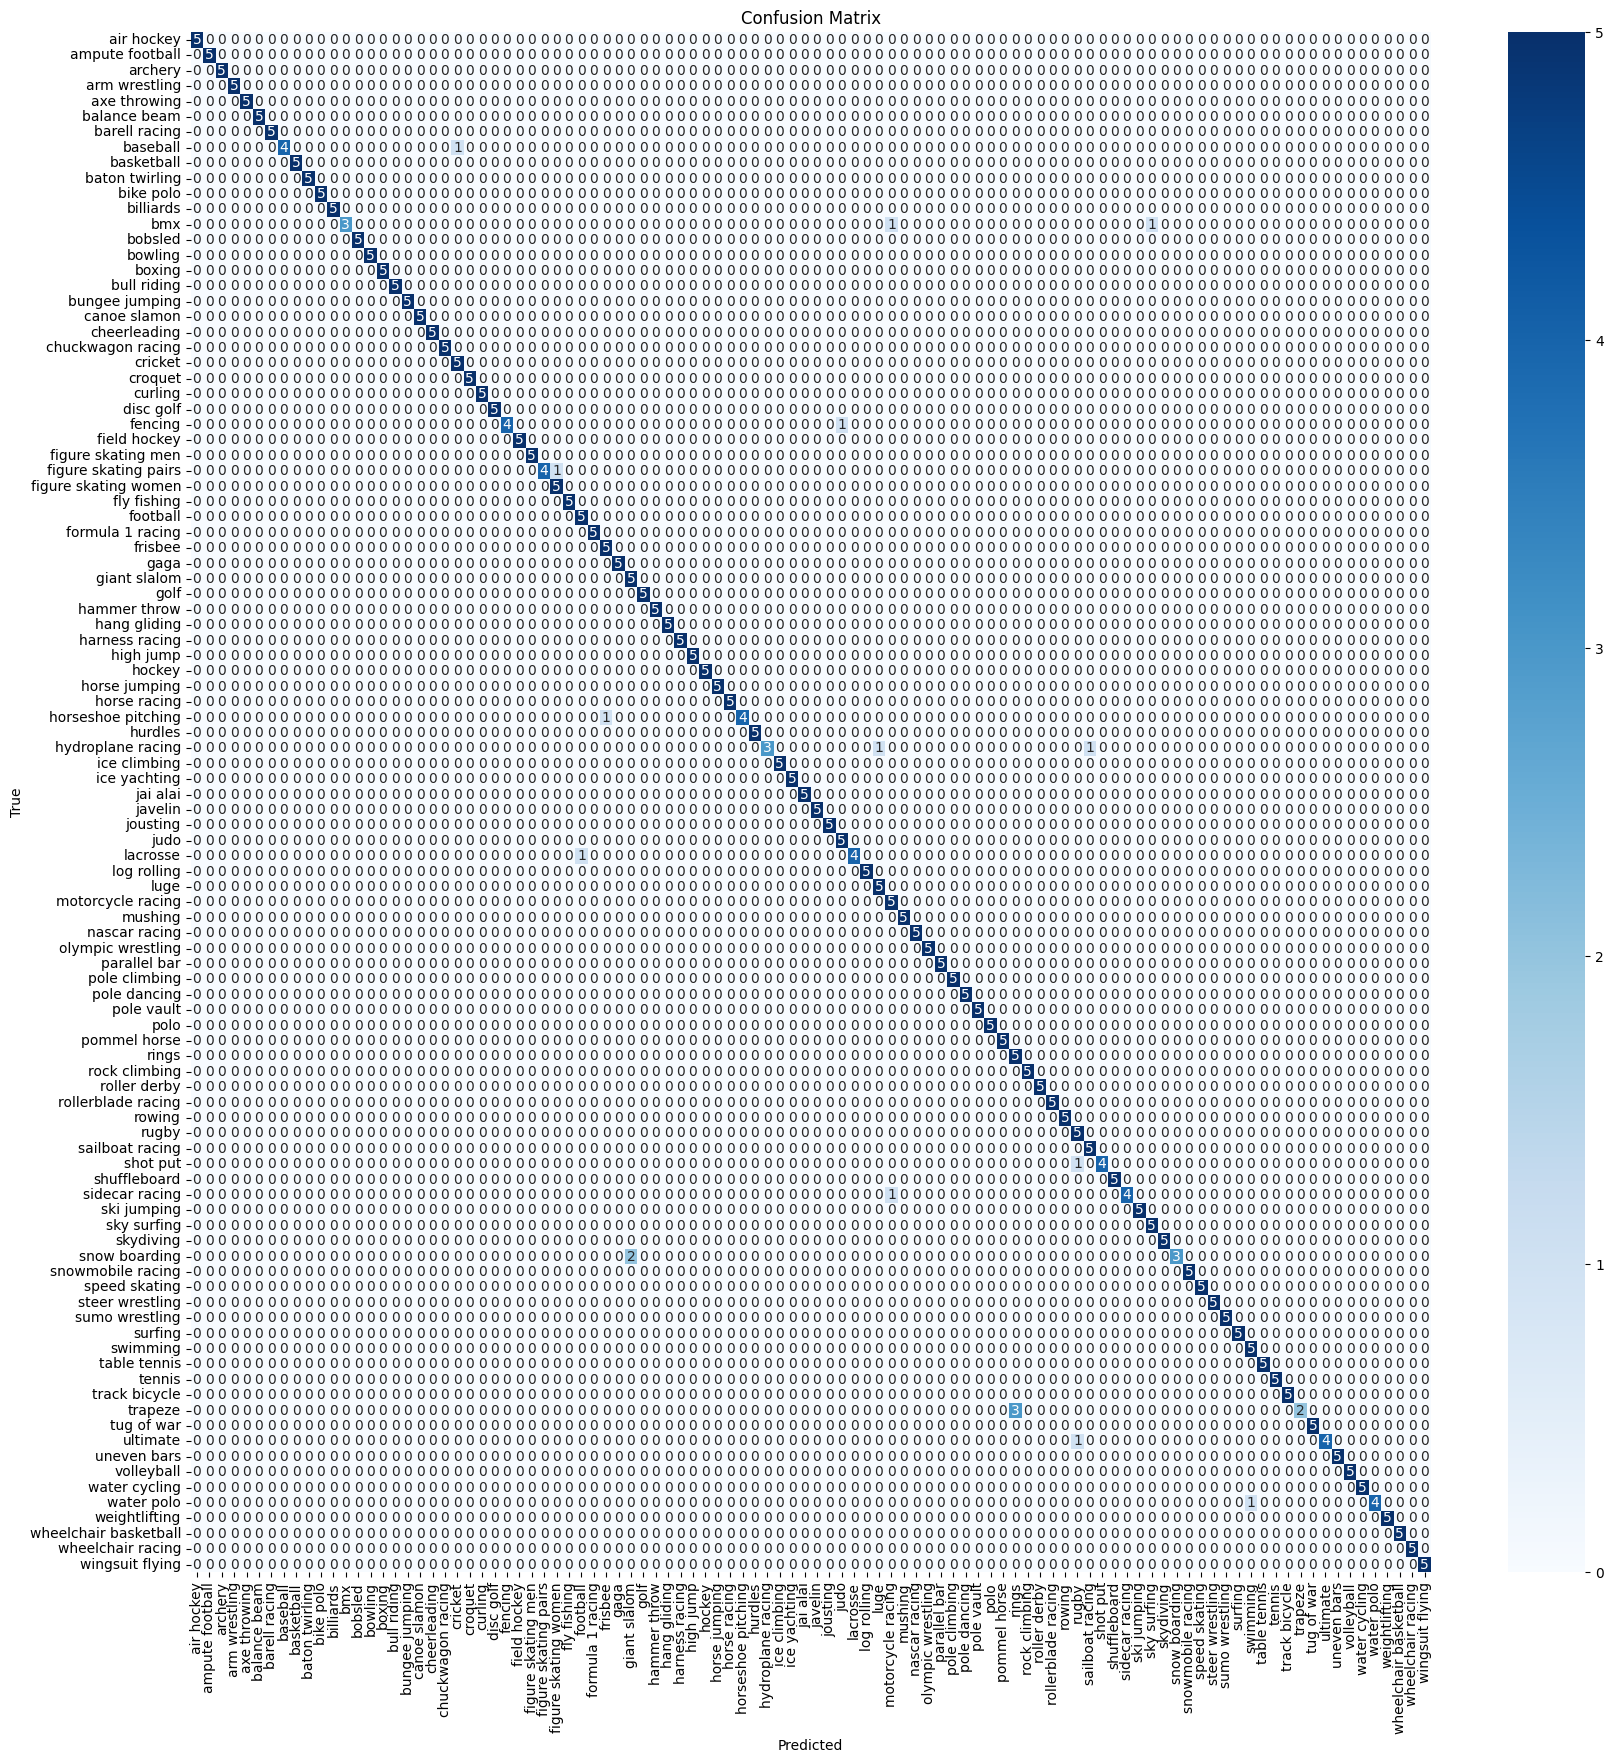

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       1.00      1.00      1.00         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.00      1.00      1.00  

In [11]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [18]:
for layer in model.layers[-20:]:
    print(layer.name)

block7a_expand_conv
block7a_expand_bn
block7a_expand_activation
block7a_dwconv
block7a_bn
block7a_activation
block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7a_project_bn
top_conv
top_bn
top_activation
avg_pool
batch_normalization
top_dropout
pred


Epoch 1/5


E0000 00:00:1745934964.519753      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745934964.728110      97 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


209/211 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.9792 - loss: 0.1485

E0000 00:00:1745934983.815507      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1745934984.025373      96 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


211/211 ━━━━━━━━━━━━━━━━━━━━ 57s 144ms/step - accuracy: 0.9791 - loss: 0.1484 - val_accuracy: 0.9680 - val_loss: 0.6112
Epoch 2/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9814 - loss: 0.1319 - val_accuracy: 0.9700 - val_loss: 0.5909
Epoch 3/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9810 - loss: 0.1188 - val_accuracy: 0.9720 - val_loss: 0.5677
Epoch 4/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9830 - loss: 0.1171 - val_accuracy: 0.9700 - val_loss: 0.5515
Epoch 5/5
211/211 ━━━━━━━━━━━━━━━━━━━━ 10s 49ms/step - accuracy: 0.9849 - loss: 0.1042 - val_accuracy: 0.9740 - val_loss: 0.5397


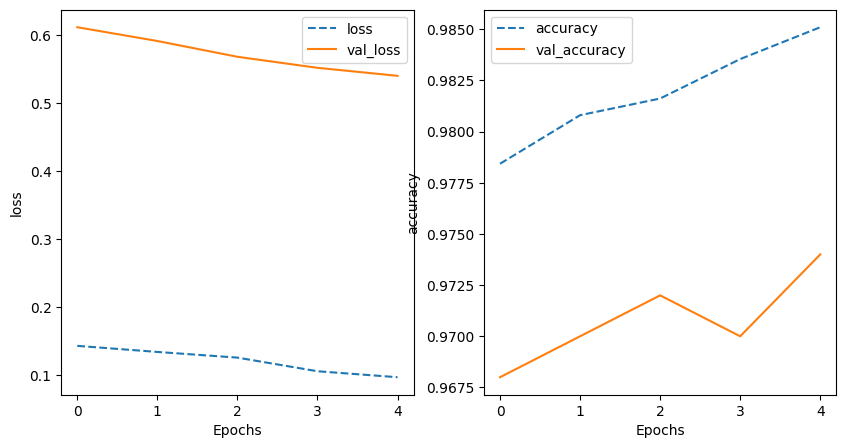

In [19]:
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )


unfreeze_model(model)
epochs = 5  # @param {type: "slider", min:4, max:10}
hist = model.fit(train_ds, epochs=epochs, validation_data=test_ds)
training_plot(['loss', 'accuracy'], hist)

In [20]:
# Get class names from the test dataset
class_names = test_ds.class_names

# Create lists to store true labels and predictions
y_true = []
y_pred = []

# Iterate through the test dataset
for images, labels in test_ds:
    # Get predictions
    predictions = model.predict(images, verbose=0)
    
    # Convert predictions to class indices
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Extend the lists with batch data
    y_true.extend(np.argmax(labels, axis=1))
    y_pred.extend(predicted_classes)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

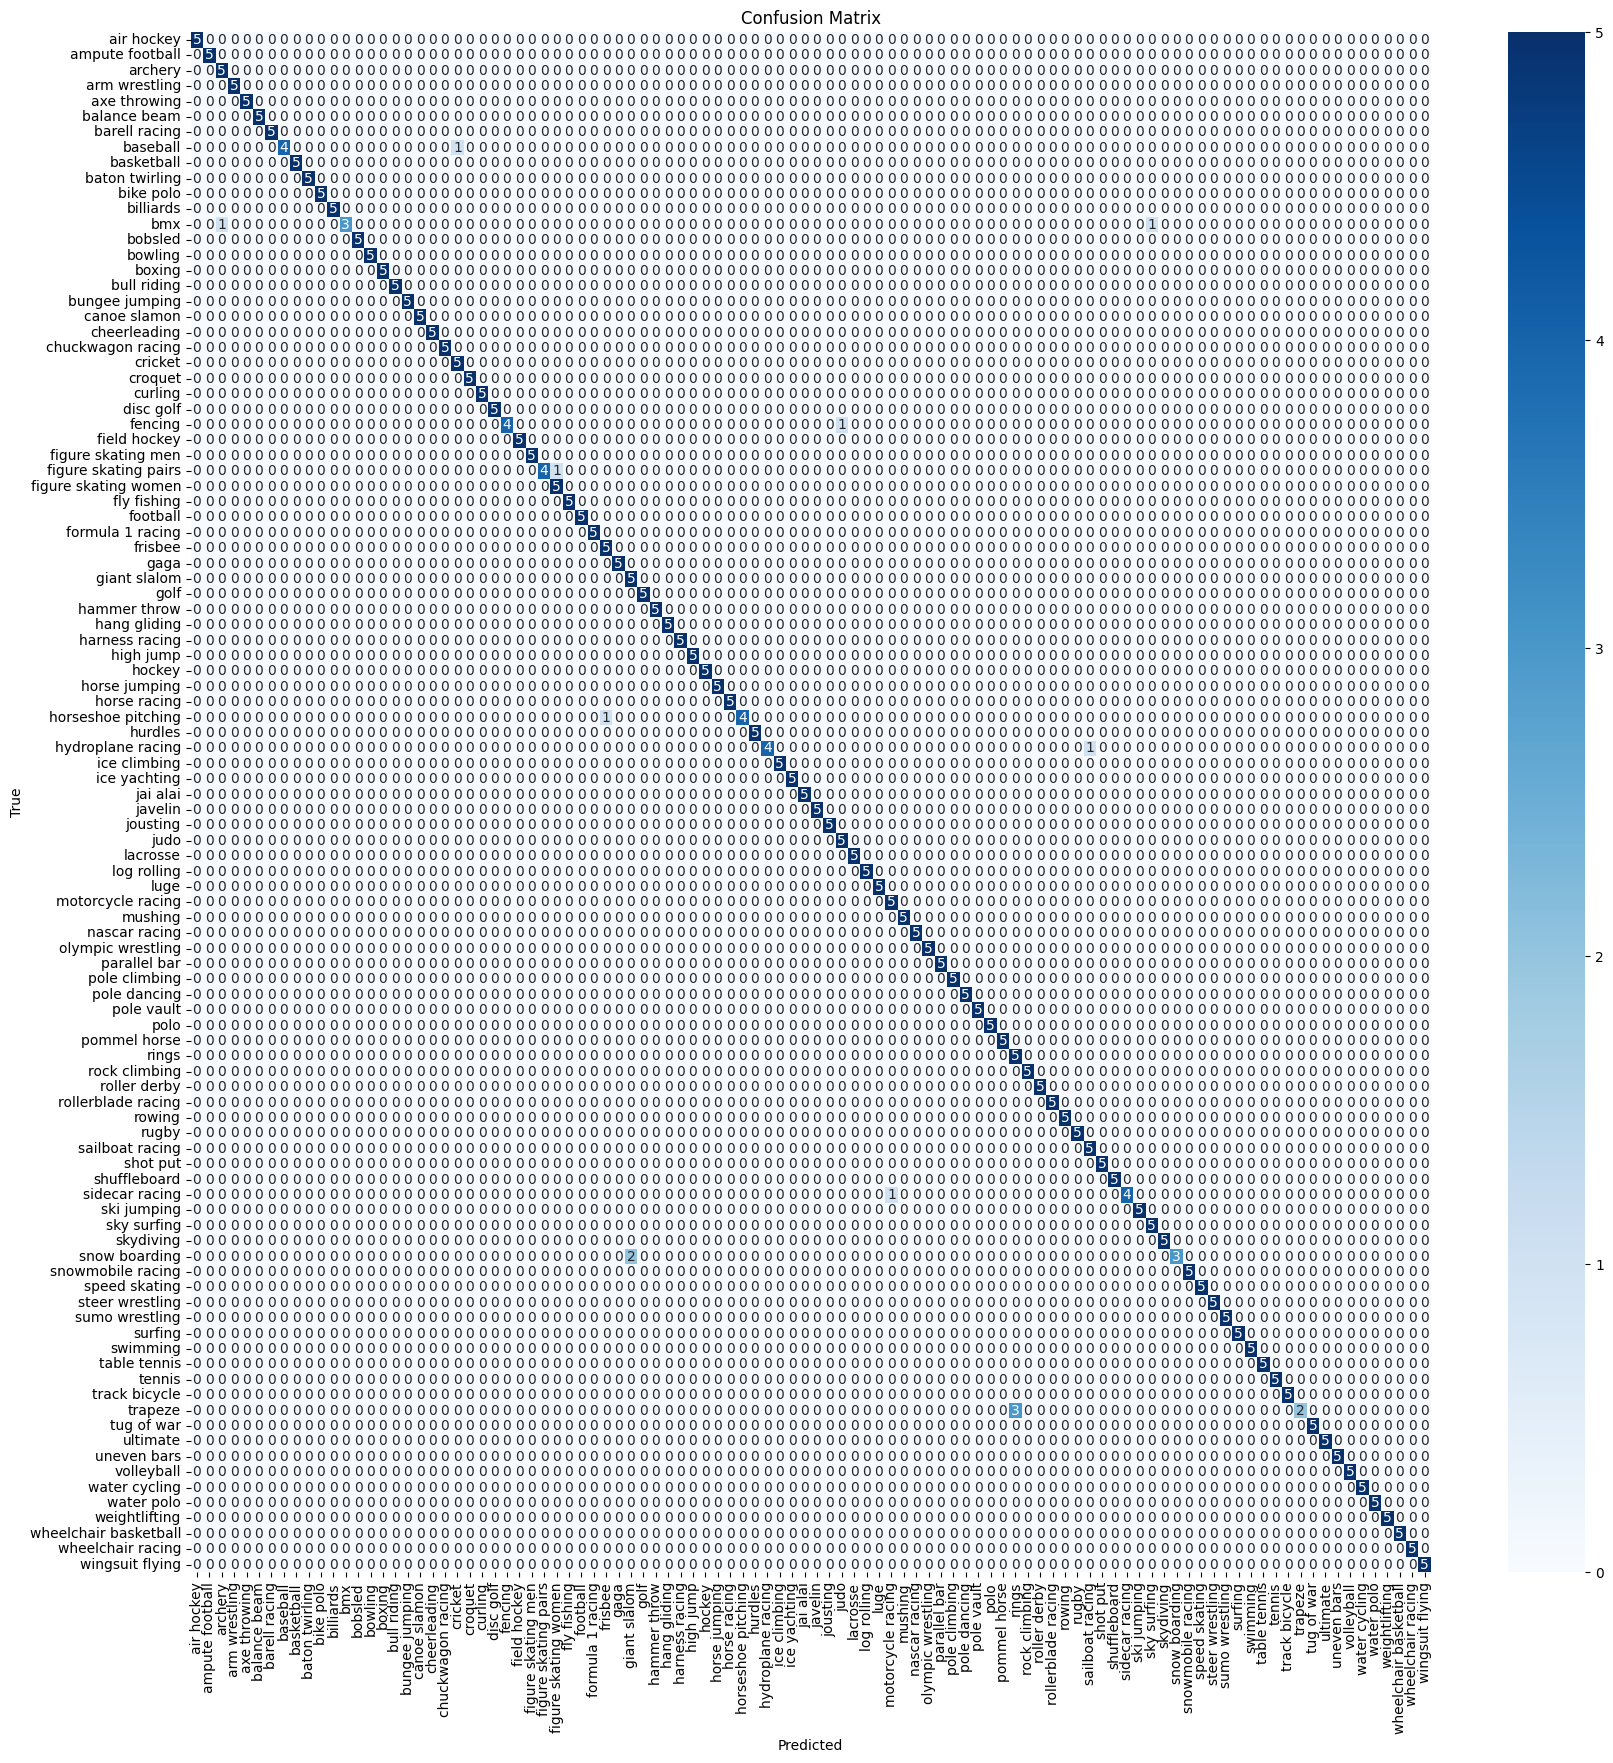

                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       0.83      1.00      0.91         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       1.00      1.00      1.00         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      1.00      1.00         5
              bowling       1.00      1.00      1.00  

In [21]:
# Plot confusion matrix
plt.figure(figsize=(20, 20))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

In [22]:
model.save("100_sport_clf.keras")